## MLP Version 2

This version is modeled off of collaborative filtering methodology. It simply takes in user_id and recipe_code in order to predict stars. The ids go through embedding layers in order for the model to learn their relationship.

In [210]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

### Data Processing

In [211]:
# Load the data from CSV
df = pd.read_csv("recipe_review_data.csv")

# Count reviews per user
review_counts = df.groupby('user_id').size()
# Get user_ids with more than 5 reviews or 10 reviews
users_over_5 = review_counts[review_counts >= 5].index
# Filter the DataFrame to include only these users
df = df[df['user_id'].isin(users_over_5)]
print("Data preview:")
df.head()

Data preview:


,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
27,27,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_432496,u_1oKVZT7bnHOk8MH7Aom0wkTCJNo,ahmom,1,1622648873,0,4,0,5,329,EXCELLENT RECIPE!! This will be on regular rot...
31,31,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_429113,u_1oKVr0FIiKTNe84vUuYXGEKMHfD,gooch621,1,1622648882,0,3,0,5,297,Outstanding just the way it is!
50,50,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_425025,u_1oKVguRYSeYopnS8TJesoAeBEsd,dylan's mama,1,1622718462,0,9,0,5,415,We have been making this for years now and its...
56,56,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_384535,u_1oKWWgyoJAqNhh1VGGmFPp24Au9,mrscessna,1,1622718272,0,0,0,4,100,Easy and tasty!
79,79,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_424088,u_1oKVchl3LINh51liAWR6aZjJEqJ,jeanemed,20,1622718447,0,0,0,5,100,Very good. I wonder if it once had cream chees...


In [212]:
# Map user and recipe ids to unique integer indices (for embeddings)
user_ids = df['user_id'].unique().tolist()
recipe_ids = df['recipe_code'].unique().tolist()

user_to_index = {user: idx for idx, user in enumerate(user_ids)}
recipe_to_index = {recipe: idx for idx, recipe in enumerate(recipe_ids)}

df['user_idx'] = df['user_id'].map(user_to_index)
df['recipe_idx'] = df['recipe_code'].map(recipe_to_index)

num_users = len(user_ids)
num_recipes = len(recipe_ids)

print(f"Number of users: {num_users}")
print(f"Number of recipes: {num_recipes}")

# Split the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


Number of users: 274
Number of recipes: 100


In [213]:
class RecipeRatingDataset(Dataset):
    def __init__(self, df):
        self.users = df['user_idx'].values
        self.recipes = df['recipe_idx'].values
        self.ratings = df['stars'].values.astype(np.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return {
            'user': torch.tensor(self.users[idx], dtype=torch.long),
            'recipe': torch.tensor(self.recipes[idx], dtype=torch.long),
            'rating': torch.tensor(self.ratings[idx], dtype=torch.float)
        }

# Create dataset objects
train_dataset = RecipeRatingDataset(train_df)
test_dataset = RecipeRatingDataset(test_df)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

### Define the Model

In [214]:
class NCFModel(nn.Module):
    def __init__(self, num_users, num_recipes, embedding_dim=50):
        super(NCFModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.recipe_embedding = nn.Embedding(num_recipes, embedding_dim)

        self.fc1 = nn.Linear(embedding_dim * 2, 128)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 1)

        self.relu = nn.ReLU()

    def forward(self, user, recipe):
        user_emb = self.user_embedding(user)
        recipe_emb = self.recipe_embedding(recipe)
        user_emb = user_emb.view(user_emb.size(0), -1)
        recipe_emb = recipe_emb.view(recipe_emb.size(0), -1)

        x = torch.cat([user_emb, recipe_emb], dim=1)
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        # Apply scaled sigmoid: output between 1 and 5
        x = 1 + 4 * torch.sigmoid(self.output_layer(x))
        return x.squeeze()

In [215]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = NCFModel(num_users=num_users, num_recipes=num_recipes, embedding_dim=50)
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

NCFModel(
  (user_embedding): Embedding(274, 50)
  (recipe_embedding): Embedding(100, 50)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)


### Train the Model and Evaluate

Epoch 1/100 - Train Loss: 1.9310, Test Loss: 0.9453
Epoch 2/100 - Train Loss: 0.9837, Test Loss: 0.9195
Epoch 3/100 - Train Loss: 0.8828, Test Loss: 0.8894
Epoch 4/100 - Train Loss: 0.8126, Test Loss: 0.8613
Epoch 5/100 - Train Loss: 0.7666, Test Loss: 0.8453
Epoch 6/100 - Train Loss: 0.7209, Test Loss: 0.8363
Epoch 7/100 - Train Loss: 0.6878, Test Loss: 0.8300
Epoch 8/100 - Train Loss: 0.6334, Test Loss: 0.8221
Epoch 9/100 - Train Loss: 0.6006, Test Loss: 0.8220
Epoch 10/100 - Train Loss: 0.5289, Test Loss: 0.8125
Epoch 11/100 - Train Loss: 0.4406, Test Loss: 0.8280
Epoch 12/100 - Train Loss: 0.3505, Test Loss: 0.8118
Epoch 13/100 - Train Loss: 0.2913, Test Loss: 0.8222
Epoch 14/100 - Train Loss: 0.2720, Test Loss: 0.8645
Epoch 15/100 - Train Loss: 0.2756, Test Loss: 0.8020
Epoch 16/100 - Train Loss: 0.2678, Test Loss: 0.7801
Epoch 17/100 - Train Loss: 0.2409, Test Loss: 0.7568
Epoch 18/100 - Train Loss: 0.2239, Test Loss: 0.8119
Epoch 19/100 - Train Loss: 0.2137, Test Loss: 0.8147
Ep

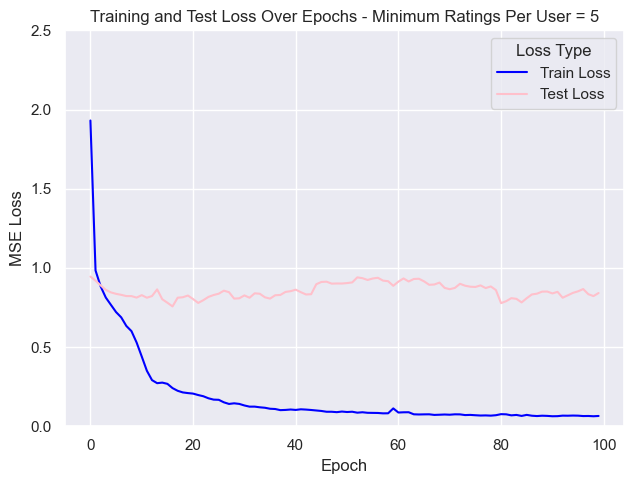

<Figure size 640x480 with 0 Axes>

In [216]:
n_epochs = 100
train_losses = []
test_losses = []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        user = batch['user'].to(device)
        recipe = batch['recipe'].to(device)
        rating = batch['rating'].to(device)

        optimizer.zero_grad()
        outputs = model(user, recipe)
        loss = criterion(outputs, rating)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on test set
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            user = batch['user'].to(device)
            recipe = batch['recipe'].to(device)
            rating = batch['rating'].to(device)

            outputs = model(user, recipe)
            loss = criterion(outputs, rating)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")


# Create an epoch range assuming train_losses and test_losses are lists/arrays
epochs = list(range(len(train_losses)))

# Create a DataFrame from the loss lists
df_loss = pd.DataFrame({
    'Epoch': epochs,
    'Train Loss': train_losses,
    'Test Loss': test_losses
})

# Melt the DataFrame to long format for Seaborn
df_long = df_loss.melt('Epoch', var_name='Loss Type', value_name='MSE Loss')

# Define a palette: change the test loss (normally orange) to pink
palette = {'Train Loss': 'blue', 'Test Loss': 'pink'}

plt.figure(figsize=(6.5, 5))
sns.set_theme(style="darkgrid")
plt.ylim(0,2.5)
sns.lineplot(data=df_long, x='Epoch', y='MSE Loss', hue='Loss Type', palette=palette)
plt.title("Training and Test Loss Over Epochs - Minimum Ratings Per User = 5")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("MLP_V2_convergence_users5.png")

### Recommendation Functionality

In [217]:
def recommend_recipes(model, user_identifier, df, top_n=5):
    """
    Recommend top_n recipes for a given user identifier (user_id or user_name) by
    referencing the original DataFrame to derive necessary mappings.

    Returns:
        A list of tuples: (recipe_id, recipe_name, predicted_rating)
    """
    # set auto user for testing purposes
    if user_identifier == None or user_identifier == "":
        user_identifier = "Jeri326"
    # Determine whether the identifier is a user_id or user_name
    if user_identifier in df['user_id'].unique():
        user_id = user_identifier
    elif 'user_name' in df.columns and user_identifier in df['user_name'].unique():
        user_id = df.loc[df['user_name'] == user_identifier, 'user_id'].iloc[0]
    else:
        print("User identifier not found in the data.")
        return []

    # Build mappings on the fly using the original DataFrame
    user_to_index = {u: i for i, u in enumerate(df['user_id'].unique())}
    recipe_to_index = {r: i for i, r in enumerate(df['recipe_code'].unique())}
    index_to_recipe = {i: r for r, i in recipe_to_index.items()}

    # Build a mapping from recipe_id to recipe_name if available; otherwise, fallback to string version of recipe_id
    if 'recipe_name' in df.columns:
        recipe_id_to_name = df.drop_duplicates(subset=['recipe_code']).set_index('recipe_code')['recipe_name'].to_dict()
    else:
        recipe_id_to_name = {r: str(r) for r in df['recipe_id'].unique()}

    # Ensure the user exists in the mapping
    if user_id not in user_to_index:
        print("User id not found in mapping.")
        return []

    user_idx = user_to_index[user_id]

    # Prepare a tensor of all recipe indices and a tensor of the user index repeated accordingly
    all_recipe_indices = torch.arange(len(recipe_to_index)).to(device)
    user_tensor = torch.full((all_recipe_indices.shape[0],), user_idx, dtype=torch.long).to(device)

    model.eval()
    with torch.no_grad():
        predictions = model(user_tensor, all_recipe_indices).cpu().numpy()

    # Find the indices of the top_n predicted ratings (highest first)
    top_indices = np.argsort(predictions)[-top_n:][::-1]

    recommendations = []
    for idx in top_indices:
        rec_recipe_id = index_to_recipe.get(idx, "Unknown")
        rec_recipe_name = recipe_id_to_name.get(rec_recipe_id, "Unknown")
        rec_rating = predictions[idx]
        recommendations.append((rec_recipe_id, rec_recipe_name, rec_rating))

    return recommendations


In [218]:
# use function
user_input = input("Enter a user id or user name: ")
recommendations = recommend_recipes(model, user_input, df, top_n=5)

print(f"\nTop 5 recipe recommendations for user '{user_input}':")
for recipe_id, recipe_name, rating in recommendations:
    print(f"Recipe ID: {recipe_id}, Recipe Name: {recipe_name} Predicted Rating: {rating:.2f}")

# compare to actual user top
if user_input == None or user_input == "":
        user_identifier = "Jeri326"
if user_input in df['user_id'].unique():
    user_id = user_input
elif 'user_name' in df.columns and user_input in df['user_name'].unique():
    user_id = df.loc[df['user_name'] == user_input, 'user_id'].iloc[0]

actual_top = df[df['user_id'] == user_id].sort_values('stars', ascending=False)
actual_top.head()


Top 5 recipe recommendations for user 'ahmom':
Recipe ID: 39581, Recipe Name: Homemade Peanut Butter Cups Predicted Rating: 5.00
Recipe ID: 12003, Recipe Name: Traditional Lasagna Predicted Rating: 5.00
Recipe ID: 1196, Recipe Name: Pumpkin Bread Predicted Rating: 5.00
Recipe ID: 11767, Recipe Name: Quick Cream of Mushroom Soup Predicted Rating: 5.00
Recipe ID: 45495, Recipe Name: Gluten-Free Banana Bread Predicted Rating: 5.00


,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text,user_idx,recipe_idx
27,27,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_432496,u_1oKVZT7bnHOk8MH7Aom0wkTCJNo,ahmom,1,1622648873,0,4,0,5,329,EXCELLENT RECIPE!! This will be on regular rot...,0,0
762,108,2,3309,Best Ever Banana Bread,sp_aUSaElGf_3309_c_331695,u_1oKVZT7bnHOk8MH7Aom0wkTCJNo,ahmom,1,1622718003,0,0,0,5,100,This turned out wonderfully. I used bananas th...,0,1
4758,302,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_139670,u_1oKVZT7bnHOk8MH7Aom0wkTCJNo,ahmom,1,1622717031,0,0,0,5,100,excellent!,0,11
6356,162,18,2872,Stuffed Pepper Soup,sp_aUSaElGf_2872_c_185471,u_1oKVZT7bnHOk8MH7Aom0wkTCJNo,ahmom,1,1622717251,0,0,0,5,100,I LOVE this soup!!,0,17
6395,201,18,2872,Stuffed Pepper Soup,sp_aUSaElGf_2872_c_139758,u_1oKVZT7bnHOk8MH7Aom0wkTCJNo,ahmom,1,1622717031,0,0,0,5,100,EXCELLENT!,0,17


### Comparison to CF Results

In [219]:
def compute_test_errors(model, test_dataset, device='cpu'):
    """
    Computes predictions and absolute errors for each instance in the test dataset.

    Parameters:
        model (nn.Module): The trained neural network model.
        test_dataset (Dataset): An instance of RecipeRatingDataset.
        device (str): Device to perform inference on ('cpu' or 'cuda').

    Returns:
        pd.DataFrame: DataFrame containing predictions and error metrics.
    """
    model.eval()  # Set model to evaluation mode
    predictions = []
    errors = []

    # Iterate over the dataset using __getitem__ method
    with torch.no_grad():
        for i in range(len(test_dataset)):
            # loop through test data and compute error
            sample = test_dataset[i]
            user_tensor = sample['user'].unsqueeze(0).to(device)    # shape: (1,)
            recipe_tensor = sample['recipe'].unsqueeze(0).to(device)  # shape: (1,)

            # Compute prediction from model
            pred = model(user_tensor, recipe_tensor)
            pred_value = pred.item()
            predictions.append(pred_value)

            # True rating
            true_rating = sample['rating'].item() if isinstance(sample['rating'], torch.Tensor) else float(sample['rating'])
            errors.append(abs(pred_value - true_rating))

    df_results = pd.DataFrame({
        'user_idx': test_dataset.users,
        'recipe_idx': test_dataset.recipes,
        'true_rating': test_dataset.ratings,
        'prediction': predictions,
        'error': errors
    })

    return df_results

mlp_errors = compute_test_errors(model, test_dataset, device='cpu')
print(mlp_errors)

     user_idx  recipe_idx  true_rating  prediction     error
0          53           0          5.0    4.996816  0.003184
1         124           6          5.0    4.997581  0.002419
2         116          61          4.0    3.997341  0.002659
3         187          46          0.0    4.898457  4.898457
4          25           4          4.0    3.861388  0.138612
..        ...         ...          ...         ...       ...
423       124          30          5.0    4.995471  0.004529
424       156          74          4.0    4.999380  0.999380
425        78          37          5.0    4.566670  0.433330
426        96           5          5.0    4.999925  0.000075
427        67          30          5.0    5.000000  0.000000

[428 rows x 5 columns]


In [220]:
# load in Cf errors
cf_errors = pd.read_csv('CF_errors.csv')
cf_errors.head()

,Unnamed: 0,error_user,error_item
0,1,-1.000000,0.000000e+00
1,2,-1.000000,8.881784e-16
2,3,-1.000000,0.000000e+00
3,4,0.585041,8.259248e-01
4,5,-0.447427,-2.275255e-01


/var/folders/_l/lwl4zghd2flbz38w_lkz9xn00000gn/T/ipykernel_18248/4064952824.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='error', y='method', palette={'MLP': 'skyblue', 'CF': 'pink'})


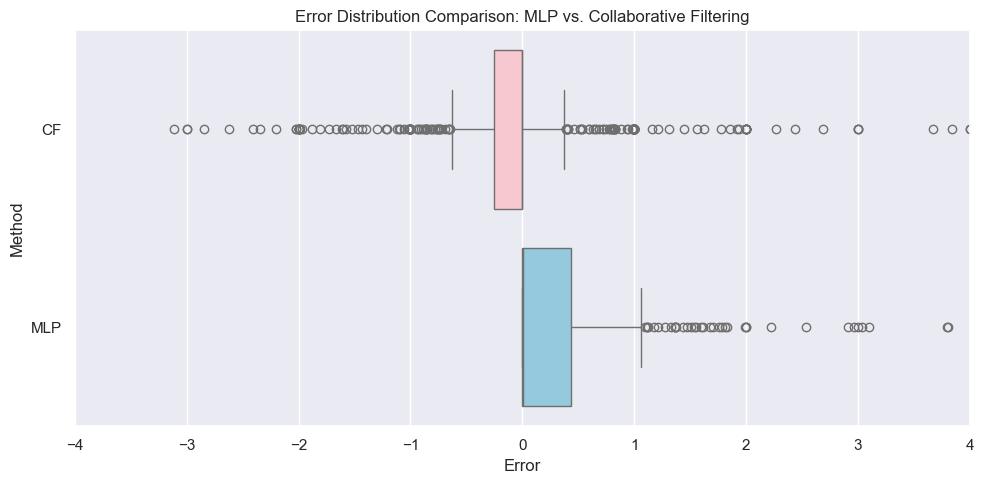

<Figure size 640x480 with 0 Axes>

In [221]:
# Add a column to identify the method
mlp_errors['method'] = 'MLP'
cf_errors['method'] = 'CF'
cf_errors.rename(columns={'error_item': 'error'}, inplace=True)

# Concatenate the DataFrames
combined_df = pd.concat([cf_errors[['error', 'method']], mlp_errors[['error', 'method']]])

# Set the Seaborn theme to the default gray background ("darkgrid")
sns.set_theme(style="darkgrid")

# Create the boxplot
plt.figure(figsize=(10, 5))
plt.xlim(-4, 4)
sns.boxplot(data=combined_df, x='error', y='method', palette={'MLP': 'skyblue', 'CF': 'pink'})
plt.title("Error Distribution Comparison: MLP vs. Collaborative Filtering")
plt.xlabel("Error")
plt.ylabel("Method")
plt.tight_layout()
plt.show()
plt.savefig('MLP_vs_Collaborative_Filtering.png')